In [40]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, classification_report, roc_auc_score
import glob
import os

## import data

In [53]:
train_path = max(glob.glob('../data/train/*.csv'), key=os.path.getctime) 
test_path = max(glob.glob('../data/test/*.csv'), key=os.path.getctime) 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)

X_train, y_train = train_df.drop('state', axis=1), train_df['state']
X_test, y_test = test_df.drop('state', axis=1), test_df['state']

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24756, 579)
(4369, 579)
(24756, 578)
(24756,)
(4369, 578)
(4369,)


## best classifiers 

In [3]:
#SVC 
svc_best = {'kernel': 'linear', 'gamma': 0.1, 'C': 0.001, 'probability':True}
svc_clf = SVC(**svc_best)
svc_clf.fit(X_train, y_train)

#LOGISTIC REGRESSION
lr_clf = LogisticRegression(max_iter=25000, C= 1.601, penalty= 'l2', solver= 'lbfgs')
lr_clf.fit(X_train, y_train)

#RANDOM FOREST
rf_best = {'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}
rf_clf = RandomForestClassifier(**rf_best)
rf_clf.fit(X_train, y_train)

#XGBOOST 
xgb_clf = XGBClassifier(n_estimators= 150, max_depth = 5, learning_rate = 0.1, subsample = 0.7, colsample_bytree = 0.7)
xgb_clf.fit(X_train, y_train)



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [4]:
#VOTING
estimators = [('rf', rf_clf), ('xgb', xgb_clf), ('logreg', lr_clf)]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')
voting_clf.fit(X_train, y_train)

#STACKING
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=10,
                                                       min_samples_leaf=6,
                                                       min_samples_split=5,
                                                       n_estimators=150)),
                               ('xgb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=0.7,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None, gamma=...
                                              learning_rate=0.1, max_bin=256,
                                              max_cat_to_onehot=4,
                                              max_delta_step=0, max_depth=5,
                                              max_leaves=0, min_child_weight=1,
                                              missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=150, n_jobs=0,
                                              num_parallel_tree=1,
                                              predictor='auto', random_state=0,
                                              reg_alpha=0, reg_lambda=1, ...)),
                               ('logreg',
                                LogisticRegression(C=1.601, max_iter=25000))],
                   final_estimator=LogisticRegression())

## NB

In [42]:
X_train_nb = X_train.copy()
X_test_nb = X_test.copy()

train_ohe_cat = X_train_nb.iloc[:, 422:437]
X_train_nb['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_train_nb.iloc[:, 437:-1]
X_train_nb['location'] = train_ohe_loc.idxmax(1)

train_ohe_cat = X_test_nb.iloc[:, 422:437]
X_test_nb['category'] = train_ohe_cat.idxmax(1)
train_ohe_loc = X_test_nb.iloc[:, 437:-1]
X_test_nb['location'] = train_ohe_loc.idxmax(1)

X_train_nb = X_train_nb.drop(X_train_nb.iloc[:, 422:-2].columns, axis=1)
X_test_nb = X_test_nb.drop(X_test_nb.iloc[:, 422:-2].columns, axis=1)

In [43]:
binary_cols = ['staff_pick', 'has_video']
categorical_cols = ['category', 'location']
train_binary = X_train_nb[binary_cols]
train_categorical = X_train_nb[categorical_cols]
test_binary = X_test_nb[binary_cols]
test_categorical = X_test_nb[categorical_cols]

In [44]:
train_numeric = X_train_nb.select_dtypes(include='number').drop(binary_cols, axis=1) 
test_numeric = X_test_nb.select_dtypes(include='number').drop(binary_cols, axis=1) 

In [45]:
# ----- Fit three models -----

model_G = GaussianNB()
clf_G = model_G.fit(train_numeric, y_train)

model_C2 = CategoricalNB()
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = np.nan)
train_categorical = enc.fit_transform(train_categorical)
test_categorical = enc.transform(test_categorical)
imp = SimpleImputer(strategy="most_frequent") 
train_categorical = imp.fit_transform(train_categorical)
test_categorical = imp.transform(test_categorical)
clf_C2 = model_C2.fit(train_categorical, y_train)

model_B = BernoulliNB()
clf_B = model_B.fit(train_binary, y_train)

# ----- Get probability predictions from each model -----
# On training data
G_train_probas = model_G.predict_proba(train_numeric)
C_train_probas = model_C2.predict_proba(train_categorical)
B_train_probas = model_B.predict_proba(train_binary)

# And on testing data
G_test_probas = model_G.predict_proba(test_numeric)
C_test_probas = model_C2.predict_proba(test_categorical)
B_test_probas = model_B.predict_proba(test_binary)

# Combine probability prediction for class=1 from both models
X_new_train = np.c_[(G_train_probas[:,1], C_train_probas[:,1], B_train_probas[:,1])] # Train
X_new_test = np.c_[(G_test_probas[:,1], C_test_probas[:,1], B_test_probas[:,1])] # Test


# ----- Fit Gaussian model on the X_new -----
model = GaussianNB()
clf = model.fit(X_new_train, y_train)
y_pred = model.predict(X_new_test)

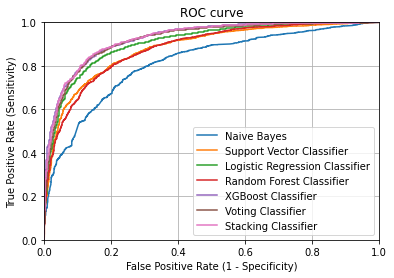

In [48]:
y_pred_prob1 = model.predict_proba(X_new_test)[:, 1]
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob1)
y_pred_prob2 = svc_clf.predict_proba(X_test)[:, 1]
fpr2, tpr2, thresholds = roc_curve(y_test, y_pred_prob2)
y_pred_prob3 = lr_clf.predict_proba(X_test)[:, 1]
fpr3, tpr3, thresholds = roc_curve(y_test, y_pred_prob3)
y_pred_prob4 = rf_clf.predict_proba(X_test)[:, 1]
fpr4, tpr4, thresholds = roc_curve(y_test, y_pred_prob4)
y_pred_prob5 = xgb_clf.predict_proba(X_test)[:, 1]
fpr5, tpr5, thresholds = roc_curve(y_test, y_pred_prob5)
y_pred_prob6 = voting_clf.predict_proba(X_test)[:, 1]
fpr6, tpr6, thresholds = roc_curve(y_test, y_pred_prob6)
y_pred_prob7 = stacking_clf.predict_proba(X_test)[:, 1]
fpr7, tpr7, thresholds = roc_curve(y_test, y_pred_prob7)

plt.plot(fpr1, tpr1, label = "Naive Bayes")
plt.plot(fpr2, tpr2, label ="Support Vector Classifier")
plt.plot(fpr3, tpr3, label = "Logistic Regression Classifier")
plt.plot(fpr4, tpr4, label ="Random Forest Classifier")
plt.plot(fpr5, tpr5, label ="XGBoost Classifier")
plt.plot(fpr6, tpr6, label ="Voting Classifier")
plt.plot(fpr7, tpr7, label ="Stacking Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)